In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
import os

def has_jfif_header(file_path):
    # Read the first 11 bytes of the file to check for JFIF header markers
    try:
        with open(file_path, 'rb') as f:
            header = f.read(11)
            return header.startswith(b'\xFF\xD8\xFF\xE0\x00\x10JFIF')
    except IOError:
        return False

def delete_corrupt_files(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not has_jfif_header(file_path):
                try:
                    os.remove(file_path)
                    print(f"Deleted: {file_path}")
                except OSError as e:
                    print(f"Error deleting: {file_path}, Error: {e}")

if __name__ == "__main__":
    directory_to_check = "PetImages"

    # List of subdirectories to check
    subdirectories = ["Cat", "Dog"]

    for subdir in subdirectories:
        full_subdir_path = os.path.join(directory_to_check, subdir)
        if os.path.exists(full_subdir_path):
            print(f"Checking {subdir} directory...")
            delete_corrupt_files(full_subdir_path)
        else:
            print(f"{subdir} directory not found.")


Checking Cat directory...
Deleted: PetImages/Cat/2114.jpg
Deleted: PetImages/Cat/4203.jpg
Deleted: PetImages/Cat/837.jpg
Deleted: PetImages/Cat/9069.jpg
Deleted: PetImages/Cat/8388.jpg
Deleted: PetImages/Cat/88.jpg
Deleted: PetImages/Cat/6602.jpg
Deleted: PetImages/Cat/12046.jpg
Deleted: PetImages/Cat/1151.jpg
Deleted: PetImages/Cat/3961.jpg
Deleted: PetImages/Cat/7285.jpg
Deleted: PetImages/Cat/12126.jpg
Deleted: PetImages/Cat/2276.jpg
Deleted: PetImages/Cat/1757.jpg
Deleted: PetImages/Cat/9492.jpg
Deleted: PetImages/Cat/1970.jpg
Deleted: PetImages/Cat/3197.jpg
Deleted: PetImages/Cat/6951.jpg
Deleted: PetImages/Cat/3183.jpg
Deleted: PetImages/Cat/7642.jpg
Deleted: PetImages/Cat/Thumbs.db
Deleted: PetImages/Cat/758.jpg
Deleted: PetImages/Cat/7865.jpg
Deleted: PetImages/Cat/5928.jpg
Deleted: PetImages/Cat/1597.jpg
Deleted: PetImages/Cat/12494.jpg
Deleted: PetImages/Cat/7864.jpg
Deleted: PetImages/Cat/7125.jpg
Deleted: PetImages/Cat/7643.jpg
Deleted: PetImages/Cat/6549.jpg
Deleted: PetIm

In [6]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23198 files belonging to 2 classes.
Using 18559 files for training.
Using 4639 files for validation.


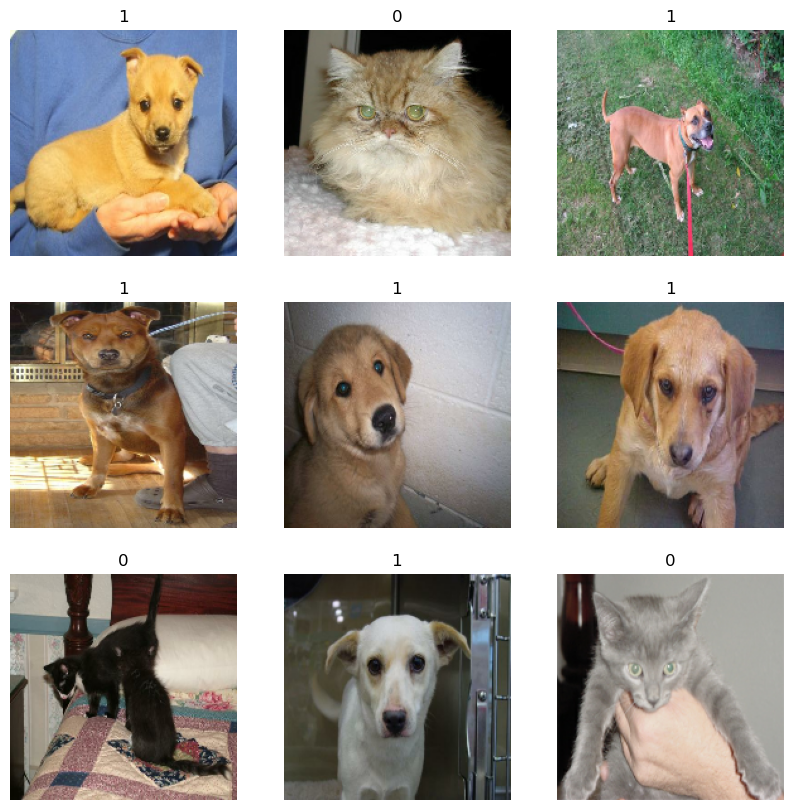

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

2023-07-26 19:50:43.132194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-26 19:50:43.258745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-26 19:50:43.319226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-26 19:50:43.375179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-26 19:50:43.436066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-26 19:50:43.494774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

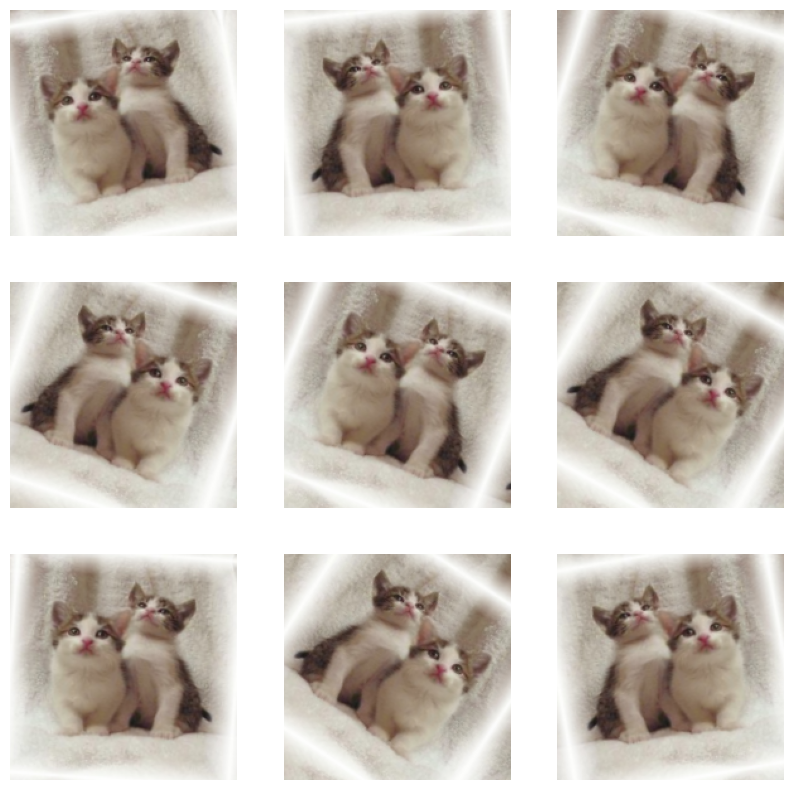

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [10]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [11]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

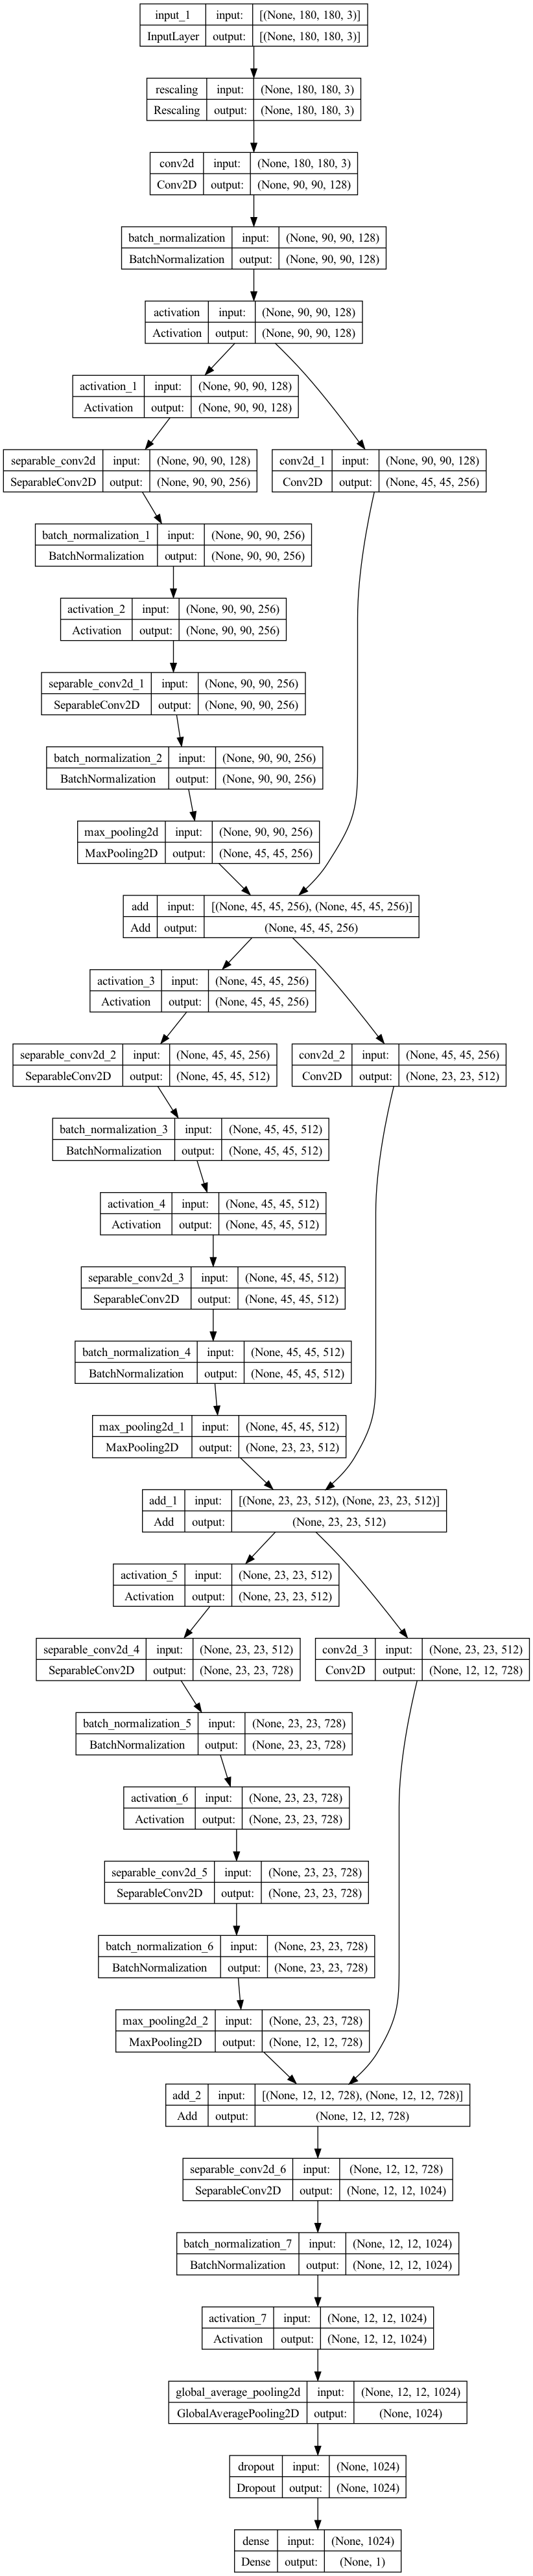

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [13]:
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

2023-07-26 19:52:06.452885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-26 19:52:06.479170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-26 19:52:06.934770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 18/145 [==>...........................] - ETA: 8:27 - loss: 0.7428 - accuracy: 0.5694

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 20/145 [===>..........................] - ETA: 8:10 - loss: 0.7412 - accuracy: 0.5707

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 24/145 [===>..........................] - ETA: 7:42 - loss: 0.7378 - accuracy: 0.5771

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/145 [====>.........................] - ETA: 7:23 - loss: 0.7380 - accuracy: 0.5799

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 30/145 [=====>........................] - ETA: 7:15 - loss: 0.7331 - accuracy: 0.5833

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 67/145 [============>.................] - ETA: 4:35 - loss: 0.6895 - accuracy: 0.6079

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 70/145 [=============>................] - ETA: 4:27 - loss: 0.6861 - accuracy: 0.6102

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 85/145 [================>.............] - ETA: 3:31 - loss: 0.6751 - accuracy: 0.6192

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 91/145 [=================>............] - ETA: 3:10 - loss: 0.6717 - accuracy: 0.6214

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 95/145 [==================>...........] - ETA: 2:56 - loss: 0.6698 - accuracy: 0.6234

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 99/145 [===================>..........] - ETA: 2:44 - loss: 0.6673 - accuracy: 0.6249

112/145 [======================>.......] - ETA: 1:59 - loss: 0.6581 - accuracy: 0.6318

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.6367 - accuracy: 0.6508

2023-07-26 20:01:16.532245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


145/145 [==============================] - 565s 4s/step - loss: 0.6367 - accuracy: 0.6508 - val_loss: 0.7356 - val_accuracy: 0.4958


In [16]:
# serialize model to JSON
model_json = model.to_json()
with open("--model1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("--model1.h5")
print("Saved model to disk")

Saved model to disk


Loaded model from disk
1/1 [==============================] - 0s 12ms/step


2023-07-26 20:09:19.078314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step


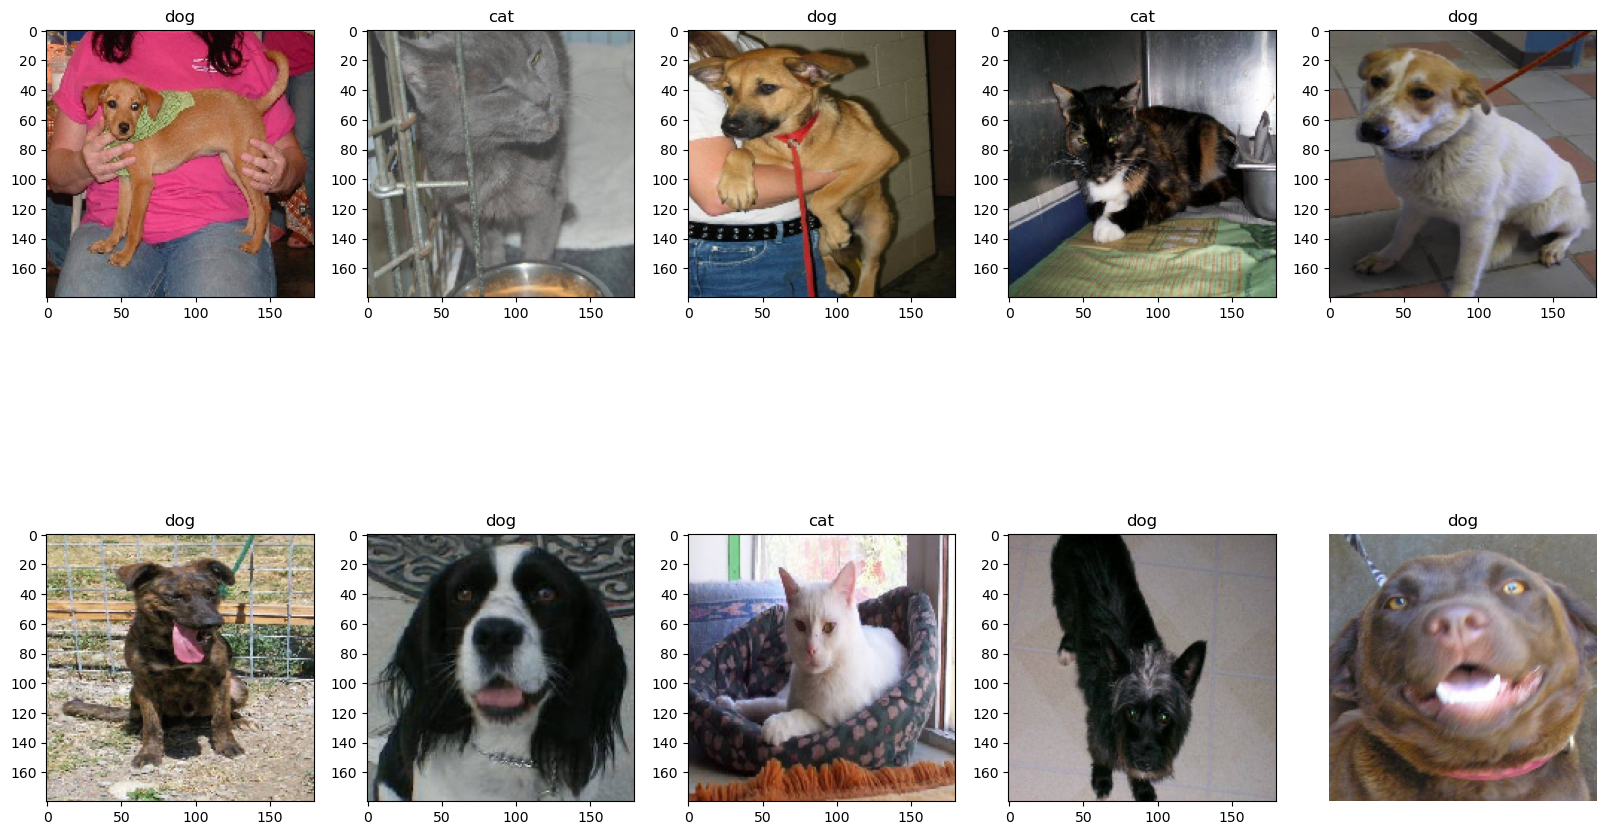

In [17]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from os import listdir
import random
from tensorflow.keras.models import model_from_json

# Load train and test data
test_dir = './catdog/test'

image_size = (180, 180)

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

for ax in axes.ravel():
    
    files = listdir(test_dir)
    i = random.choice(files)
        
    img_path = os.path.join(test_dir, '{}'.format(i))
    
    img = keras.utils.load_img(
    img_path, target_size=image_size)

    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis



    predictions = loaded_model.predict(img_array)
    score = float(predictions[0])

    if 100 * score > 50 :
        label = 'dog'
    else :
        label = 'cat'
    ax.set_title(label)
    ax.imshow(img)
plt.axis('off')
plt.show()